# Detecção em escala aleatória de sequências do MNIST

## Importando módulos

In [1]:
import os
import pkgutil

if pkgutil.find_loader('torch') is None:
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if os.path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import OrderedDict

import torch
import torchvision
from torchvision.datasets import MNIST

import cv2

In [3]:
np.set_printoptions(precision=1, linewidth=120)
torch.set_printoptions(precision=1, linewidth=120)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Device:", device)

Device: cuda


## Dataset

In [5]:
dataset_dir = '../data/MNIST/processed/'
num_scales = 2
max_len = 7

In [6]:
class RandomScaleSeqMNIST(torch.utils.data.Dataset):
    def __init__(self, processed_data_dir, length, mat_size=280, num_scales=2,
                 min_size=28, max_size=52, max_len=7, debug=False):
        num_attempts = 20

        self.length = length
        self.num_scales = num_scales

        # 28 30 32 34 36 38 40 42 44 46 48 50
        digit_size_array = np.arange(min_size, max_size, 2)
        self.digit_size_ref_delta = (max_size - min_size) / num_scales
        self.digit_size_ref = np.array([min_size + self.digit_size_ref_delta * idx for idx in range(num_scales)])

        num_cells = (mat_size / self.digit_size_ref).astype('int').tolist()
        self.cell_central_pixel = [np.arange(size_ref/2, mat_size, size_ref) for size_ref in self.digit_size_ref]
        cell_pixel_between = [(central_array[:-1] + central_array[1:]) // 2 for central_array in self.cell_central_pixel]

        if debug:
            print(f'digit_size_ref_delta: {self.digit_size_ref_delta}')
            print(f'digit_size_array: {digit_size_array}')
            print(f'digit_size_ref: {self.digit_size_ref}')
            print(f'num_cells: {num_cells}')
            print(f'cell_central_pixel: {self.cell_central_pixel}')
            print(f'cell_pixel_between: {cell_pixel_between}')
            print('\n')

        test_data, test_label = torch.load(os.path.join(processed_data_dir, 'test.pt'))
        train_data, train_label = torch.load(os.path.join(processed_data_dir, 'training.pt'))

        self.joint_data = torch.cat((train_data, test_data), dim=0).type(torch.FloatTensor) / 255.0
        self.joint_label = torch.cat((train_label, test_label), dim=0)

        data_idx_array = np.arange(self.joint_data.shape[0])

        self.mat_image = torch.zeros((self.length, 1, mat_size, mat_size), dtype=torch.float)
        self.mat_label_reg = list()
        self.mat_label_cls = list()
        for entry in num_cells:
            self.mat_label_reg.append(torch.zeros((self.length, 2, entry, entry), dtype=torch.float))
            self.mat_label_cls.append(torch.zeros((self.length, 3, entry, entry), dtype=torch.long))
            self.mat_label_cls[-1][:, 0] = -1

        for sample_idx in range(self.length):
            frame_list = list()

            num_numbers = np.random.randint(10, 20)
            for data_idx in range(num_numbers):
                # Choose digit size among options and get closest size reference
                digit_size = np.random.choice(digit_size_array)
                digit_size_diff = digit_size - self.digit_size_ref

                digit_size_ref_idx = np.argmin(np.abs(digit_size_diff))
                if digit_size_diff[digit_size_ref_idx] < 0:
                    digit_size_ref_idx -= 1

                digit_size_delta = digit_size_diff[digit_size_ref_idx]

                # Get number_len that fits based on digit_size
                len_upper_limit = int(np.minimum(np.floor(mat_size / digit_size), max_len))

                number_len = np.random.randint(1, len_upper_limit)
                number_size = digit_size * number_len

                digit_attempt = 0
                while digit_attempt != num_attempts:
                    nx1 = np.random.randint(0, mat_size-number_size)
                    ny1 = np.random.randint(0, mat_size-digit_size)
                    nx2, ny2 = nx1+number_size, ny1+digit_size

                    frame_idx = 0
                    while frame_idx != len(frame_list):
                        frame_x1, frame_y1, frame_x2, frame_y2 = frame_list[frame_idx]

                        nx1_between = (nx1 >= frame_x1) and (nx1 < frame_x2)
                        nx2_between = (nx2 >= frame_x1) and (nx2 < frame_x2)

                        ny1_between = (ny1 >= frame_y1) and (ny1 < frame_y2)
                        ny2_between = (ny2 >= frame_y1) and (ny2 < frame_y2)

                        frame_x1_between = (frame_x1 >= nx1) and (frame_x1 < nx2)
                        frame_x2_between = (frame_x2 >= nx1) and (frame_x2 < nx2)

                        frame_y1_between = (frame_y1 >= ny1) and (frame_y1 < ny2)
                        frame_y2_between = (frame_y2 >= ny1) and (frame_y2 < ny2)

                        x_between = nx1_between or nx2_between or frame_x1_between or frame_x2_between
                        y_between = ny1_between or ny2_between or frame_y1_between or frame_y2_between

                        if x_between and y_between:
                            break
                        else:
                            frame_idx += 1

                    if frame_idx == len(frame_list):
                        frame_list.append([nx1, ny1, nx2, ny2])
                        break
                    else:
                        digit_attempt += 1

                if digit_attempt != num_attempts:
                    np.random.shuffle(data_idx_array)

                    y_centroid = ny1 + (digit_size // 2)
                    y_centroid_diff = cell_pixel_between[digit_size_ref_idx] - y_centroid
                    y_closest_pixel = np.argmin(np.abs(y_centroid_diff))
                    y_central_pixel_idx = y_closest_pixel if y_centroid_diff[y_closest_pixel] >= 0 else y_closest_pixel + 1
                    y_central_pixel = self.cell_central_pixel[digit_size_ref_idx][y_central_pixel_idx]
                    ty = cell_pixel_between[digit_size_ref_idx][y_closest_pixel] - y_centroid_diff[y_closest_pixel] - y_central_pixel

                    dx1 = nx1
                    dx2 = dx1 + digit_size
                    for idx in range(number_len):
                        digit_idx = data_idx_array[idx]

                        digit_array = cv2.resize(self.joint_data[digit_idx].numpy(), dsize=(digit_size, digit_size))
                        self.mat_image[sample_idx, 0, ny1:ny2, dx1:dx2] = torch.from_numpy(digit_array)

                        dx1 += digit_size
                        dx2 += digit_size

                    dx1 = nx1
                    # Compute distance of digit centroid to each cell interface to pick the right cell and tx/ty
                    x_centroid = dx1 + (digit_size // 2)
                    x_centroid_diff = cell_pixel_between[digit_size_ref_idx] - x_centroid
                    x_closest_pixel = np.argmin(np.abs(x_centroid_diff))
                    x_central_pixel_idx = x_closest_pixel if x_centroid_diff[x_closest_pixel] >= 0 else x_closest_pixel + 1
                    x_central_pixel = self.cell_central_pixel[digit_size_ref_idx][x_central_pixel_idx]
                    tx = cell_pixel_between[digit_size_ref_idx][x_closest_pixel] - x_centroid_diff[x_closest_pixel] - x_central_pixel

                    self.mat_label_reg[digit_size_ref_idx][sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = tx
                    self.mat_label_reg[digit_size_ref_idx][sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = ty
                    self.mat_label_cls[digit_size_ref_idx][sample_idx, 0, y_central_pixel_idx, x_central_pixel_idx] = digit_size_delta // 2
                    self.mat_label_cls[digit_size_ref_idx][sample_idx, 1, y_central_pixel_idx, x_central_pixel_idx] = number_len
                    self.mat_label_cls[digit_size_ref_idx][sample_idx, 2, y_central_pixel_idx, x_central_pixel_idx] = 1
                    #self.mat_label_cls[digit_size_ref_idx][sample_idx, 3, y_central_pixel_idx, x_central_pixel_idx] = self.joint_label[digit_idx]

        if not debug:
            for idx in range(len(self.mat_label_reg)):
                self.mat_label_reg[idx][:, :2] /= self.digit_size_ref[idx] / 2
                self.mat_label_cls[idx][:, 1] -= 1

    def getDigitSize(self):
        return self.digit_size_ref

    def getDigitSizeRefDelta(self):
        return self.digit_size_ref_delta

    def getCellCentralRef(self):
        return self.cell_central_pixel

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        label_reg = list()
        label_cls = list()

        for scale in range(self.num_scales):
            label_reg.append(self.mat_label_reg[scale][index])
            label_cls.append(self.mat_label_cls[scale][index])

        return self.mat_image[index], label_reg, label_cls

### Visualização de exemplo

In [7]:
def printSample(dataset, idx):
    image, label_reg_list, label_cls_list = dataset[idx]

    for scale_idx in range(num_scales):
        print(f'\nScale {scale_idx}')
        print(f'tx:\n{label_reg_list[scale_idx][0]}\n')
        print(f'ty:\n{label_reg_list[scale_idx][1]}\n')
        print(f'size:\n{label_cls_list[scale_idx][0]}\n')
        print(f'length:\n{label_cls_list[scale_idx][1]}\n')
        print(f'presence:\n{label_cls_list[scale_idx][2]}\n')

def vizSample(dataset, idx, digit_size_array, digit_central_ref_array):
    text_fontsize = 14

    image, label_reg_list, label_cls_list = dataset[idx]

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image[0].numpy(), cmap='Greys')
    ax.grid(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    digit_info = list()
    digit_idx = 0

    for scale_idx in range(num_scales):
        digit_central_ref = digit_central_ref_array[scale_idx]

        label_reg = label_reg_list[scale_idx]
        label_cls = label_cls_list[scale_idx]

        digit_size_mat = digit_size_array[scale_idx] + (label_cls[0] * 2)

        digit_coord_array = label_cls[2].nonzero()
        for digit_coord in digit_coord_array:
            digit_coord_y = digit_coord[0].item()
            digit_coord_x = digit_coord[1].item()

            digit_size = int(digit_size_mat[digit_coord_y, digit_coord_x].item())
            delta_size = digit_size / 2

            digit_x = (digit_central_ref[digit_coord_x] + label_reg[0][digit_coord_y, digit_coord_x]).item() - delta_size
            digit_y = (digit_central_ref[digit_coord_y] + label_reg[1][digit_coord_y, digit_coord_x]).item() - delta_size

            number_len = label_cls[1][digit_coord_y, digit_coord_x].item()
            number_size = number_len * digit_size

            digit_info.append({
                #'Class': label_cls[0][digit_coord_y, digit_coord_x].item(),
                'size': digit_size,
                'length': number_len,
                'tx': label_reg[0][digit_coord_y, digit_coord_x].item(),
                'ty': label_reg[1][digit_coord_y, digit_coord_x].item(),
                'coord': [digit_x, digit_y, digit_x+number_size, digit_y+digit_size]
            })

            ax.add_patch(patches.Rectangle([digit_x, digit_y], number_size, digit_size,
                                           fill=False, edgecolor='blue', lw=2))
            ax.text(digit_x, digit_y+(text_fontsize//2), str(digit_idx), fontsize=text_fontsize)

            digit_idx += 1

    key_list = ['size', 'length', 'tx', 'ty', 'coord']

    for idx in range(digit_idx):
        digit_str = f'Number {idx} > '

        for key in key_list:
            digit_str += f'{key}:{digit_info[idx][key]}'
            if key != key_list[-1]:
                digit_str += ' | '

        print(digit_str)

    #plt.axis('off')
    plt.show()

In [8]:
mnist_dataset = RandomScaleSeqMNIST(dataset_dir, 1, num_scales=num_scales, max_len=max_len, debug=True)
digit_size_array = mnist_dataset.getDigitSize()
digit_size_ref_delta = mnist_dataset.getDigitSizeRefDelta()
digit_central_ref_array = mnist_dataset.getCellCentralRef()

digit_size_ref_delta: 12.0
digit_size_array: [28 30 32 34 36 38 40 42 44 46 48 50]
digit_size_ref: [28. 40.]
num_cells: [10, 7]
cell_central_pixel: [array([ 14.,  42.,  70.,  98., 126., 154., 182., 210., 238., 266.]), array([ 20.,  60., 100., 140., 180., 220., 260.])]
cell_pixel_between: [array([ 28.,  56.,  84., 112., 140., 168., 196., 224., 252.]), array([ 40.,  80., 120., 160., 200., 240.])]




Number 0 > size:32 | length:2 | tx:1.0 | ty:-3.0 | coord:[27.0, 51.0, 91.0, 83.0]
Number 1 > size:30 | length:5 | tx:-10.0 | ty:-10.0 | coord:[101.0, 45.0, 251.0, 75.0]
Number 2 > size:38 | length:5 | tx:-4.0 | ty:-10.0 | coord:[19.0, 97.0, 209.0, 135.0]
Number 3 > size:34 | length:2 | tx:14.0 | ty:-3.0 | coord:[39.0, 162.0, 107.0, 196.0]
Number 4 > size:44 | length:4 | tx:-5.0 | ty:2.0 | coord:[73.0, 0.0, 249.0, 44.0]
Number 5 > size:48 | length:1 | tx:14.0 | ty:1.0 | coord:[210.0, 117.0, 258.0, 165.0]
Number 6 > size:44 | length:1 | tx:-3.0 | ty:4.0 | coord:[195.0, 202.0, 239.0, 246.0]
Number 7 > size:50 | length:1 | tx:18.0 | ty:-13.0 | coord:[53.0, 222.0, 103.0, 272.0]


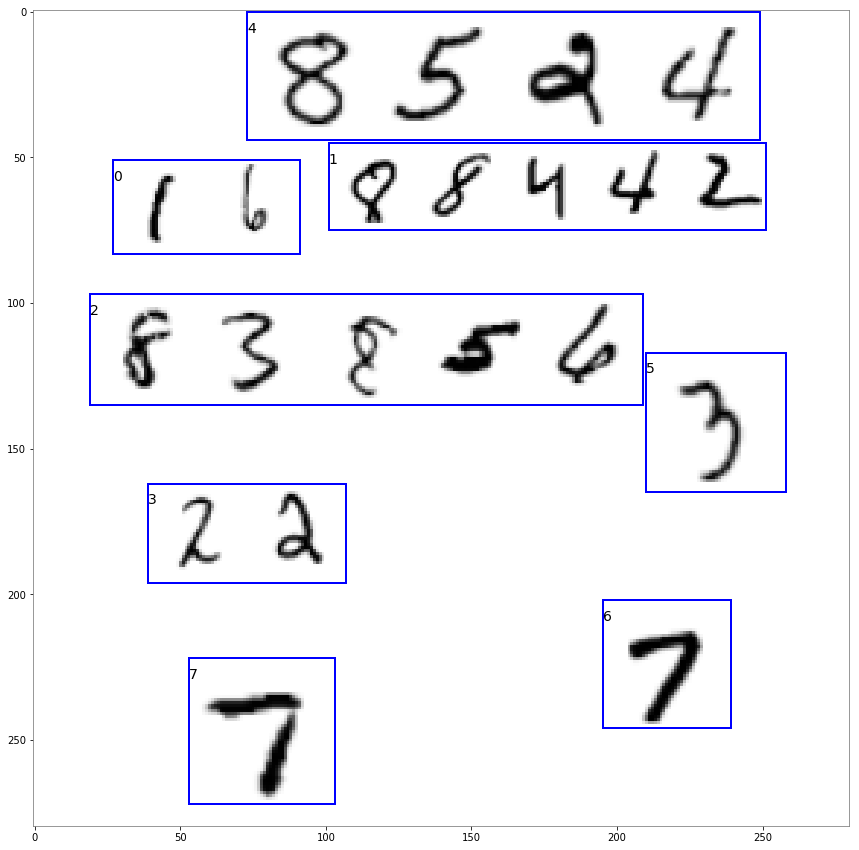

In [9]:
vizSample(mnist_dataset, 0, digit_size_array, digit_central_ref_array)

In [10]:
printSample(mnist_dataset, 0)


Scale 0
tx:
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   1.,   0.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

ty:
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  -3.,   0.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
 

### Criação dos datasets de Treinamento, Validação e Teste

In [11]:
num_samples_train = 6000
num_samples_valid = 1200
num_samples_test = 600

dataset_train = RandomScaleSeqMNIST(dataset_dir, num_samples_train, num_scales=num_scales)
dataset_valid = RandomScaleSeqMNIST(dataset_dir, num_samples_valid, num_scales=num_scales)
dataset_test = RandomScaleSeqMNIST(dataset_dir, num_samples_test, num_scales=num_scales)

## Dataloaders

In [12]:
batch_size = 12

dataloaders = {
    'train': torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0),
    'valid': torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=0)
}

## Modelo de Rede Neural

In [13]:
size_cls_depth = int(digit_size_ref_delta // 2)
length_cls_depth = max_len - 1
presence_cls_depth = 2

cls_depth = [size_cls_depth, length_cls_depth, presence_cls_depth]
reg_depth = 2
label_depth = sum(cls_depth) + reg_depth

In [14]:
class RandomScaleSeqModel(torch.nn.Module):
    def __init__(self, label_depth):
        super(RandomScaleSeqModel, self).__init__()

        num_conv_layers = 20
        depth_array = [int(label_depth + (idx * 2)) for idx in range(num_conv_layers-1, -1, -1)]
        print(depth_array)

        self.feat = torch.nn.Sequential(OrderedDict([
            # 280 > 140
            ('conv_280_1', torch.nn.Conv2d(in_channels=1, out_channels=depth_array[0], kernel_size=3, padding=1)),
            ('relu_280_1', torch.nn.LeakyReLU()),
            ('conv_280_2', torch.nn.Conv2d(in_channels=depth_array[0], out_channels=depth_array[1], kernel_size=3, padding=1)),
            ('relu_280_2', torch.nn.LeakyReLU()),
            ('conv_280_3', torch.nn.Conv2d(in_channels=depth_array[1], out_channels=depth_array[2], kernel_size=3, padding=1)),
            ('relu_280_3', torch.nn.LeakyReLU()),
            ('maxpool_280_140', torch.nn.MaxPool2d(kernel_size=2)),
            # 140 > 70
            ('conv_140_1', torch.nn.Conv2d(in_channels=depth_array[2], out_channels=depth_array[3], kernel_size=3, padding=1)),
            ('relu_140_1', torch.nn.LeakyReLU()),
            ('conv_140_2', torch.nn.Conv2d(in_channels=depth_array[3], out_channels=depth_array[4], kernel_size=3, padding=1)),
            ('relu_140_2', torch.nn.LeakyReLU()),
            ('conv_140_3', torch.nn.Conv2d(in_channels=depth_array[4], out_channels=depth_array[5], kernel_size=3, padding=1)),
            ('relu_140_3', torch.nn.LeakyReLU()),
            ('maxpool_140_70', torch.nn.MaxPool2d(kernel_size=2)),
            # 70 > 34
            ('conv_70_1', torch.nn.Conv2d(in_channels=depth_array[5], out_channels=depth_array[6], kernel_size=3, padding=1)),
            ('relu_70_1', torch.nn.LeakyReLU()),
            ('conv_70_2', torch.nn.Conv2d(in_channels=depth_array[6], out_channels=depth_array[7], kernel_size=3, padding=1)),
            ('relu_70_2', torch.nn.LeakyReLU()),
            ('conv_68_3', torch.nn.Conv2d(in_channels=depth_array[7], out_channels=depth_array[8], kernel_size=3)),
            ('relu_68_3', torch.nn.LeakyReLU()),
            ('conv_68_4', torch.nn.Conv2d(in_channels=depth_array[8], out_channels=depth_array[9], kernel_size=3, padding=1)),
            ('relu_68_4', torch.nn.LeakyReLU()),
            ('maxpool_68_34', torch.nn.MaxPool2d(kernel_size=2)),
            # 34 > 14
            ('conv_34_1', torch.nn.Conv2d(in_channels=depth_array[9], out_channels=depth_array[10], kernel_size=3, padding=1)),
            ('relu_34_1', torch.nn.LeakyReLU()),
            ('conv_34_2', torch.nn.Conv2d(in_channels=depth_array[10], out_channels=depth_array[11], kernel_size=3, padding=1)),
            ('relu_34_2', torch.nn.LeakyReLU()),
            ('conv_32_3', torch.nn.Conv2d(in_channels=depth_array[11], out_channels=depth_array[12], kernel_size=3)),
            ('relu_32_3', torch.nn.LeakyReLU()),
            ('conv_32_4', torch.nn.Conv2d(in_channels=depth_array[12], out_channels=depth_array[13], kernel_size=3, padding=1)),
            ('relu_32_4', torch.nn.LeakyReLU()),
            ('maxpool_32_16', torch.nn.MaxPool2d(kernel_size=2)),
            # 16 > 14
            ('conv_16_1', torch.nn.Conv2d(in_channels=depth_array[13], out_channels=depth_array[14], kernel_size=3, padding=1)),
            ('relu_16_1', torch.nn.LeakyReLU()),
            ('conv_16_2', torch.nn.Conv2d(in_channels=depth_array[14], out_channels=depth_array[15], kernel_size=3, padding=1)),
            ('relu_16_2', torch.nn.LeakyReLU()),
            ('conv_14_3', torch.nn.Conv2d(in_channels=depth_array[15], out_channels=depth_array[16], kernel_size=3)),
            ('relu_14_3', torch.nn.LeakyReLU()),
            ('conv_14_4', torch.nn.Conv2d(in_channels=depth_array[16], out_channels=depth_array[17], kernel_size=3, padding=1)),
            ('relu_14_4', torch.nn.LeakyReLU()),
        ]))

        self.scale_0 = torch.nn.Sequential(OrderedDict([
            # 14 > 10
            ('conv_12_1', torch.nn.Conv2d(in_channels=depth_array[17], out_channels=depth_array[18], kernel_size=3)),
            ('relu_12_1', torch.nn.LeakyReLU()),
            ('conv_10_2', torch.nn.Conv2d(in_channels=depth_array[18], out_channels=depth_array[19], kernel_size=3))
        ]))

        self.scale_1 = torch.nn.Sequential(OrderedDict([
            # 14 > 7
            ('maxpool_14_7', torch.nn.MaxPool2d(kernel_size=2)),
            ('conv_7_1', torch.nn.Conv2d(in_channels=depth_array[17], out_channels=depth_array[18], kernel_size=3, padding=1)),
            ('relu_7_1', torch.nn.LeakyReLU()),
            ('conv_7_2', torch.nn.Conv2d(in_channels=depth_array[18], out_channels=depth_array[19], kernel_size=3, padding=1))
        ]))

    def forward(self, x):
        f = self.feat(x)
        x = self.scale_0(f)
        y = self.scale_1(f)

        return [x, y]

## Função de perda customizada

In [15]:
class RandomScaleSeqLoss(torch.nn.Module):
    def __init__(self, reg_depth, cls_depth, num_scales):
        super().__init__()
        self.reg_depth = reg_depth
        self.cls_depth = cls_depth
        self.num_scales = num_scales

        self.size_upper_limit = self.reg_depth + self.cls_depth[0]
        self.length_upper_limit = self.size_upper_limit + self.cls_depth[1]

        presence_weights = torch.tensor([0.1, 1]).to(device)

        self.cel_size = torch.nn.CrossEntropyLoss(ignore_index=-1)
        self.cel_length = torch.nn.CrossEntropyLoss(ignore_index=-1)
        self.cel_presence = torch.nn.CrossEntropyLoss(weight=presence_weights)

    def customMSELoss(self, predict, target, mask):
        num_elem = torch.sum(mask, (3, 2, 1))
        num_elem[num_elem == 0] = 1
        mse_loss_calc_1 = (predict - target) ** 2
        mse_loss_calc_2 = torch.sum(mse_loss_calc_1 * mask, (3, 2, 1)) / num_elem
        return torch.sum(mse_loss_calc_2) / len(mse_loss_calc_2)

    def forward(self, predict_list, target_reg_list, target_cls_list, debug=False):
        loss_size = list()
        loss_length = list()
        loss_presence = list()
        loss_t = list()

        for scale_idx in range(self.num_scales):
            predict_scale = predict_list[scale_idx].to(device)
            target_reg_scale = target_reg_list[scale_idx].to(device)
            target_cls_scale = target_cls_list[scale_idx].to(device)

            loss_size.append(self.cel_size(predict_scale[:, self.reg_depth:self.size_upper_limit],
                                           target_cls_scale[:, 0]))
            loss_length.append(self.cel_length(predict_scale[:, self.size_upper_limit:self.length_upper_limit],
                                               target_cls_scale[:, 1]))
            loss_presence.append(self.cel_presence(predict_scale[:, self.length_upper_limit:],
                                                   target_cls_scale[:, 2]))

            loss_t.append(self.customMSELoss(predict_scale[:, :self.reg_depth], target_reg_scale,
                                             target_cls_scale[:, 2:].type(torch.float)))

        if debug:
            print(f'loss_size: {loss_size}')
            print(f'loss_length: {loss_length}')
            print(f'loss_presence: {loss_presence}')
            print(f'loss_t: {loss_t}')

        return sum(loss_size + loss_length + loss_presence + loss_t)

## Teste das etapas (dataloader, modelo e função de perda)

In [16]:
label_entries = ['tx', 'ty', 'size', 'len']

dataiter = iter(dataloaders['train'])
sample_images, sample_labels_reg_list, sample_labels_cls_list = dataiter.next()

print(f'Input')
print(f'    Format: {sample_images.shape}')
print(f'    Type: {sample_images.dtype}')
print(f'    Range: [{sample_images.min()}, {sample_images.max()}]')
print('\n')

print(f'Label')
for scale_idx in range(num_scales):
    print(f'    Scale {scale_idx}')
    print(f'        Regression')
    print(f'            Format: {sample_labels_reg_list[scale_idx].shape}')
    print(f'            Type: {sample_labels_reg_list[scale_idx].dtype}')
    print(f'            Range:')
    print(f'                tx: [{sample_labels_reg_list[scale_idx][:, 0].min()}, {sample_labels_reg_list[scale_idx][:, 0].max()}]')
    print(f'                ty: [{sample_labels_reg_list[scale_idx][:, 1].min()}, {sample_labels_reg_list[scale_idx][:, 1].max()}]')
    print(f'        Classification')
    print(f'            Format: {sample_labels_cls_list[scale_idx].shape}')
    print(f'            Type: {sample_labels_cls_list[scale_idx].dtype}')
    print(f'            Range:')
    print(f'                size: [{sample_labels_cls_list[scale_idx][:, 0].min()}, {sample_labels_cls_list[scale_idx][:, 0].max()}]')
    print(f'                length: [{sample_labels_cls_list[scale_idx][:, 1].min()}, {sample_labels_cls_list[scale_idx][:, 1].max()}]')
    print(f'                presence: [{sample_labels_cls_list[scale_idx][:, 2].min()}, {sample_labels_cls_list[scale_idx][:, 2].max()}]')

Input
    Format: torch.Size([12, 1, 280, 280])
    Type: torch.float32
    Range: [0.0, 1.0]


Label
    Scale 0
        Regression
            Format: torch.Size([12, 2, 10, 10])
            Type: torch.float32
            Range:
                tx: [-0.9285714030265808, 1.0]
                ty: [-0.9285714030265808, 1.0]
        Classification
            Format: torch.Size([12, 3, 10, 10])
            Type: torch.int64
            Range:
                size: [-1, 5]
                length: [-1, 5]
                presence: [0, 1]
    Scale 1
        Regression
            Format: torch.Size([12, 2, 7, 7])
            Type: torch.float32
            Range:
                tx: [-0.8999999761581421, 1.0]
                ty: [-0.8999999761581421, 1.0]
        Classification
            Format: torch.Size([12, 3, 7, 7])
            Type: torch.int64
            Range:
                size: [-1, 5]
                length: [-1, 5]
                presence: [0, 1]


In [17]:
random_scale_seq_model = RandomScaleSeqModel(label_depth).to(device)
sample_images = sample_images.to(device)
output_list = random_scale_seq_model(sample_images)

print(f'Output')
for scale_idx in range(num_scales):
    print(f'    Scale {num_scales - scale_idx}')
    print(f'        Format: {output_list[scale_idx].shape}')
    print(f'        Type: {output_list[scale_idx].dtype}')
    print(f'        Range: [{output_list[scale_idx].min()}, {output_list[scale_idx].max()}]')

[54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16]
Output
    Scale 2
        Format: torch.Size([12, 16, 10, 10])
        Type: torch.float32
        Range: [-0.0645703375339508, 0.04963096231222153]
    Scale 1
        Format: torch.Size([12, 16, 7, 7])
        Type: torch.float32
        Range: [-0.07156797498464584, 0.09123221039772034]


In [18]:
crit = RandomScaleSeqLoss(reg_depth, cls_depth, num_scales)
loss = crit(output_list, sample_labels_reg_list, sample_labels_cls_list, debug=True)
print(f'loss: {loss}')

loss_size: [tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
loss_length: [tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(1.8, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
loss_presence: [tensor(0.7, device='cuda:0', grad_fn=<NllLoss2DBackward>), tensor(0.7, device='cuda:0', grad_fn=<NllLoss2DBackward>)]
loss_t: [tensor(0.7, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.7, device='cuda:0', grad_fn=<DivBackward0>)]
loss: 9.981634140014648


## Treinamento

In [19]:
n_epochs = 100

optm = torch.optim.Adam(params=random_scale_seq_model.parameters(), lr=1.e-4, betas=(0.9, 0.999))
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)

In [20]:
def train_session(model, dataloaders, num_epochs, optimizer, criterion, epoch_train_loss_history, epoch_valid_loss_history):
    num_train_samples = len(dataloaders['train'].dataset)
    num_valid_samples = len(dataloaders['valid'].dataset)
    train_batch_size = dataloaders['train'].batch_size
    valid_batch_size = dataloaders['valid'].batch_size

    num_train_batches = num_train_samples // train_batch_size
    num_valid_batches = num_valid_samples // valid_batch_size

    batch_print_size = 10

    print('Start training for {} epochs'.format(num_epochs))

    try:
        for epoch in range(num_epochs):  # loop over the dataset multiple times
            train_t0 = time.time()
            epoch_train_loss = 0.0
            running_loss = 0.0

            for i, samples in enumerate(dataloaders['train']):
                # get the inputs
                images = samples[0].to(device)
                labels_reg_list = samples[1]
                labels_cls_list = samples[2]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                output_list = model(images)
                loss = criterion(output_list, labels_reg_list, labels_cls_list)
                loss_value = loss.cpu().item()
                loss.backward()
                optimizer.step()

                # Update loss totals
                running_loss += loss_value
                epoch_train_loss += loss_value

                # print statistics
                if i % batch_print_size == (batch_print_size - 1):
                    print(f'Train batch {i+1}/{num_train_batches}: loss {running_loss/batch_print_size}', end='\r')
                    running_loss = 0.0

            epoch_train_loss /= num_train_samples
            train_t1 = time.time() - train_t0


            valid_t0 = time.time()
            epoch_valid_loss = 0.0
            running_loss = 0.0

            with torch.no_grad():
                for i, samples in enumerate(dataloaders['valid']):
                    # get the inputs
                    images = samples[0].to(device)
                    labels_reg_list = samples[1]
                    labels_cls_list = samples[2]

                    # forward
                    output_list = model(images)
                    loss = criterion(output_list, labels_reg_list, labels_cls_list)
                    loss_value = loss.cpu().item()

                    # Update loss totals
                    running_loss += loss_value
                    epoch_valid_loss += loss_value

                    # print statistics
                    if i % batch_print_size == (batch_print_size - 1):
                        print(f'Valid batch {i+1}/{num_valid_batches}: loss {running_loss/batch_print_size}', end='\r')
                        running_loss = 0.0

            epoch_valid_loss /= num_valid_samples
            valid_t1 = time.time() - valid_t0

            epoch_train_loss_history.append(epoch_train_loss)
            epoch_valid_loss_history.append(epoch_valid_loss)

            print(f'Epoch {epoch:3d} > train: T={train_t1:5.1f}s | loss={epoch_train_loss}  valid: T={valid_t1:5.1f}s | loss={epoch_valid_loss}')

        print('Finished Training')
    except KeyboardInterrupt:
        print('Finished by user')

In [21]:
def save_loss_history(loss_history_list, loss_history_filename):
    file_obj = open(loss_history_filename, 'w')
    for entry in loss_history_list:
        file_obj.write(str(entry) + '\n')
    file_obj.close()

def load_loss_history(loss_history_filename):
    loss_history_list = list()

    file_obj = open(loss_history_filename, 'r')
    for line in file_obj:
        loss_history_list.append(float(line.strip()))
    file_obj.close()

    return loss_history_list

In [22]:
train = False
load_previous_state = True
epoch_train_loss_history_filename = 'epoch_train_loss_history.txt'
epoch_valid_loss_history_filename = 'epoch_valid_loss_history.txt'
saved_model_filename = './random_scale_seq_model'

In [23]:
if load_previous_state:
    random_scale_seq_model.load_state_dict(torch.load(saved_model_filename))
    epoch_train_loss_history = load_loss_history(epoch_train_loss_history_filename)
    epoch_valid_loss_history = load_loss_history(epoch_valid_loss_history_filename)
else:
    epoch_train_loss_history = list()
    epoch_valid_loss_history = list()

if train:
    train_session(random_scale_seq_model, dataloaders, n_epochs, optm, crit,
                  epoch_train_loss_history, epoch_valid_loss_history)
    torch.save(random_scale_seq_model.state_dict(), saved_model_filename)
    save_loss_history(epoch_train_loss_history, epoch_train_loss_history_filename)
    save_loss_history(epoch_valid_loss_history, epoch_valid_loss_history_filename)

Start training for 100 epochs
Epoch   0 > train: T=345.1s | loss=0.7849976162910461  valid: T= 20.5s | loss=0.7580407055219015
Epoch   1 > train: T=345.7s | loss=0.7184928138256073  valid: T= 20.5s | loss=0.6853535175323486
Epoch   2 > train: T=346.2s | loss=0.6570696967442831  valid: T= 20.5s | loss=0.6441776470343272
Epoch   3 > train: T=346.1s | loss=0.6198913079102834  valid: T= 20.5s | loss=0.60766552845637
Epoch   4 > train: T=346.2s | loss=0.594504307905833  valid: T= 20.5s | loss=0.5854285037517548
Epoch   5 > train: T=346.4s | loss=0.5747813131809235  valid: T= 20.5s | loss=0.5726292451222738
Epoch   6 > train: T=346.6s | loss=0.5569878557523091  valid: T= 20.5s | loss=0.5517613124847413
Epoch   7 > train: T=346.6s | loss=0.5422240279515584  valid: T= 20.5s | loss=0.5427504332860311
Epoch   8 > train: T=346.6s | loss=0.5287380038897197  valid: T= 20.5s | loss=0.5393564144770304
Epoch   9 > train: T=346.6s | loss=0.5144335098266601  valid: T= 20.5s | loss=0.5149118459224701
Epo

Epoch  83 > train: T=346.6s | loss=0.17987053759892782  valid: T= 20.5s | loss=0.22483282625675202
Epoch  84 > train: T=346.8s | loss=0.17853182957569758  valid: T= 20.5s | loss=0.23200100739796956
Epoch  85 > train: T=346.8s | loss=0.1782299169898033  valid: T= 20.5s | loss=0.2393484155337016
Epoch  86 > train: T=346.8s | loss=0.17494109582901002  valid: T= 20.5s | loss=0.2406323343515396
Epoch  87 > train: T=346.7s | loss=0.1753171028693517  valid: T= 20.5s | loss=0.23642609238624573
Epoch  88 > train: T=346.4s | loss=0.17157969572146733  valid: T= 20.5s | loss=0.22549041201670963
Epoch  89 > train: T=346.3s | loss=0.17318984148899713  valid: T= 20.5s | loss=0.23621289173762003
Epoch  90 > train: T=346.6s | loss=0.1692290429075559  valid: T= 20.5s | loss=0.22132252722978593
Epoch  91 > train: T=346.5s | loss=0.16765500968694688  valid: T= 20.5s | loss=0.23425905148188272
Epoch  92 > train: T=346.5s | loss=0.16769254750013352  valid: T= 20.5s | loss=0.23510560830434163
Epoch  93 > tra

### Evolução do treinamento

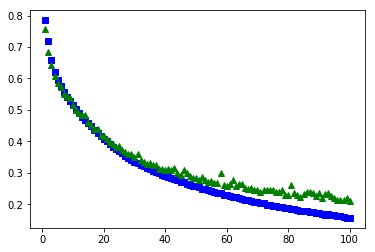

In [24]:
a_epochs = np.arange(1, 1 + len(epoch_train_loss_history))
plt.plot(a_epochs, epoch_train_loss_history, 'bs', a_epochs, epoch_valid_loss_history, 'g^')
plt.show()

### Cálculo da acurácia no conjunto de testes

In [65]:
test_loss = list()

test_image = list()

test_label_reg = dict()
test_label_size = dict()
test_label_length = dict()
test_label_presence = dict()

test_output_reg = dict()
test_output_size = dict()
test_output_length = dict()
test_output_presence = dict()
test_output_confidence = dict()

size_upper_limit = reg_depth + size_cls_depth
length_upper_limit = size_upper_limit + length_cls_depth

for scale_idx in range(num_scales):
    test_label_reg[scale_idx] = list()
    test_label_size[scale_idx] = list()
    test_label_length[scale_idx] = list()
    test_label_presence[scale_idx] = list()

    test_output_reg[scale_idx] = list()
    test_output_size[scale_idx] = list()
    test_output_length[scale_idx] = list()
    test_output_presence[scale_idx] = list()
    test_output_confidence[scale_idx] = list()

with torch.no_grad():
    for i, samples in enumerate(dataset_test):
        # get the inputs
        images = samples[0].unsqueeze(0).to(device)

        labels_reg_list = list()
        labels_cls_list = list()
        for scale_idx in range(num_scales):
            labels_reg_list.append(samples[1][scale_idx].unsqueeze(0))
            labels_cls_list.append(samples[2][scale_idx].unsqueeze(0))

        # forward
        output_list = random_scale_seq_model(images)
        loss = crit(output_list, labels_reg_list, labels_cls_list)

        test_loss.append(loss.cpu().item())

        test_image.append(samples[0].numpy())

        for scale_idx in range(num_scales):
            scale = num_scales - scale_idx
            test_label_reg[scale_idx].append(samples[1][scale_idx].numpy())
            test_output_reg[scale_idx].append(output_list[scale_idx][0, :reg_depth].cpu().numpy())

            samples_cls_array = samples[2][scale_idx].numpy()
            test_label_size[scale_idx].append(samples_cls_array[0])
            test_output_size[scale_idx].append(np.argmax(output_list[scale_idx][0, reg_depth:size_upper_limit].cpu().numpy(), axis=0))

            test_label_length[scale_idx].append(samples_cls_array[1])
            test_output_length[scale_idx].append(np.argmax(output_list[scale_idx][0, size_upper_limit:length_upper_limit].cpu().numpy(), axis=0))

            test_label_presence[scale_idx].append(samples_cls_array[2])
            test_output_presence[scale_idx].append(np.argmax(output_list[scale_idx][0, length_upper_limit:].cpu().numpy(), axis=0))

            presence_sum = np.sum(np.abs(output_list[scale_idx][0, length_upper_limit:].cpu().numpy()), axis=0)
            presence_1 = output_list[scale_idx][0, length_upper_limit+1:].cpu().numpy()
            presence_1_neg = presence_1 < 0
            test_output_confidence[scale_idx].append(np.abs(presence_1_neg - (presence_1 / presence_sum)) * test_output_presence[scale_idx][-1])

In [66]:
test_loss_array = np.array(test_loss)
test_loss_idx = np.argsort(test_loss_array)

test_arrays = {
    'image_array': np.concatenate(test_image),
    'label_reg_array': dict(),
    'output_reg_array': dict(),
    'label_size_array': dict(),
    'output_size_array': dict(),
    'label_length_array': dict(),
    'output_length_array': dict(),
    'label_presence_array': dict(),
    'output_presence_array': dict(),
    'output_confidence_array': dict()
}

for scale_idx in range(num_scales):
    test_arrays['label_reg_array'][scale_idx] = np.stack(test_label_reg[scale_idx])
    test_arrays['output_reg_array'][scale_idx] = np.stack(test_output_reg[scale_idx])
    test_arrays['label_size_array'][scale_idx] = np.stack(test_label_size[scale_idx])
    test_arrays['output_size_array'][scale_idx] = np.stack(test_output_size[scale_idx])
    test_arrays['label_length_array'][scale_idx] = np.stack(test_label_length[scale_idx])
    test_arrays['output_length_array'][scale_idx] = np.stack(test_output_length[scale_idx])
    test_arrays['label_presence_array'][scale_idx] = np.stack(test_label_presence[scale_idx])
    test_arrays['output_presence_array'][scale_idx] = np.stack(test_output_presence[scale_idx])
    test_arrays['output_confidence_array'][scale_idx] = np.concatenate(test_output_confidence[scale_idx])

    test_arrays['label_reg_array'][scale_idx][:, :2] *= (digit_size_array[scale_idx] / 2)
    test_arrays['output_reg_array'][scale_idx][:, :2] *= (digit_size_array[scale_idx] / 2)
    test_arrays['label_length_array'][scale_idx] += 1
    test_arrays['output_length_array'][scale_idx] += 1

In [67]:
def getResultBBox(arrays_dict, idx, digit_size_array, digit_central_ref_array):
    number_info = {
        'label': list(),
        'output': list()
    }

    number_idx = {
        'label': 0,
        'output': 0
    }

    for scale_idx in range(num_scales):
        digit_central_ref = digit_central_ref_array[scale_idx]

        reg_dict = dict()
        size_dict = dict()
        length_dict = dict()
        presence_dict = dict()
        digit_size_mat_dict = dict()
        number_size_mat_dict = dict()
        digit_coord_array_dict = dict()

        reg_dict['label'] = arrays_dict["label_reg_array"][scale_idx][idx]
        size_dict['label'] = arrays_dict["label_size_array"][scale_idx][idx]
        length_dict['label'] = arrays_dict["label_length_array"][scale_idx][idx]
        presence_dict['label'] = arrays_dict["label_presence_array"][scale_idx][idx]

        reg_dict['output'] = arrays_dict["output_reg_array"][scale_idx][idx]
        size_dict['output'] = arrays_dict["output_size_array"][scale_idx][idx]
        length_dict['output'] = arrays_dict["output_length_array"][scale_idx][idx]
        presence_dict['output'] = arrays_dict["output_presence_array"][scale_idx][idx]

        confidence_array = arrays_dict["output_confidence_array"][scale_idx][idx]

        digit_size_mat_dict['label'] = digit_size_array[scale_idx] + size_dict['label'] * 2
        digit_size_mat_dict['output'] = digit_size_array[scale_idx] + size_dict['output'] * 2

        number_size_mat_dict['label'] = digit_size_mat_dict['label'] * length_dict['label']
        number_size_mat_dict['output'] = digit_size_mat_dict['output'] * length_dict['output']

        digit_coord_array_dict['label'] = presence_dict['label'].nonzero()
        digit_coord_array_dict['output'] = presence_dict['output'].nonzero()

        for key in ['label', 'output']:
            for digit_coord_idx in range(len(digit_coord_array_dict[key][0])):
                digit_coord_y = digit_coord_array_dict[key][0][digit_coord_idx]
                digit_coord_x = digit_coord_array_dict[key][1][digit_coord_idx]

                digit_size = int(digit_size_mat_dict[key][digit_coord_y, digit_coord_x])
                number_size = int(number_size_mat_dict[key][digit_coord_y, digit_coord_x])
                delta_size = digit_size / 2

                digit_x = (digit_central_ref[digit_coord_x] + reg_dict[key][0][digit_coord_y, digit_coord_x]) - delta_size
                digit_y = (digit_central_ref[digit_coord_y] + reg_dict[key][1][digit_coord_y, digit_coord_x]) - delta_size

                number_info[key].append({
                    'idx': number_idx[key],
                    'digit_size': digit_size,
                    'number_size': number_size,
                    'digit_x': digit_x,
                    'digit_y': digit_y,
                    'length': int(length_dict[key][digit_coord_y, digit_coord_x]),
                    'tx': reg_dict[key][0][digit_coord_y, digit_coord_x],
                    'ty': reg_dict[key][1][digit_coord_y, digit_coord_x],
                    'coord': np.array([digit_x, digit_y, digit_x+number_size, digit_y+digit_size])
                })

                if key == 'output':
                    number_info[key][-1]['confidence'] = confidence_array[digit_coord_y, digit_coord_x]

                number_idx[key] += 1

    info_dict = {
        'label': ['digit_size', 'length', 'tx', 'ty', 'coord'],
        'output': ['digit_size', 'length', 'confidence', 'tx', 'ty', 'coord']
    }

    for key in info_dict:
        print(key)
        for idx in range(number_idx[key]):
            number_str = f'Number {idx} > '

            for info in info_dict[key]:
                try:
                    number_str += f'{info}:{number_info[key][idx][info]:5.1f}'
                except:
                    number_str += f'{info}:{number_info[key][idx][info]}'
                if info != info_dict[key][-1]:
                    number_str += ' | '

            print(number_str)

        print('\n')

    return number_info

def vizResult(image_array, idx, number_info):
    text_fontsize = 14
    bbox_color_dict = {
        'label': 'blue',
        'output': 'red'
    }

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image_array[idx], cmap='Greys')
    ax.grid(False)
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    for scale_idx in range(num_scales):
        for key in ['label', 'output']:
            for info in number_info[key]:
                ax.add_patch(patches.Rectangle([info['digit_x'], info['digit_y']], info['number_size'], info['digit_size'],
                                               fill=False, edgecolor=bbox_color_dict[key], lw=2))
                ax.text(info['digit_x'], info['digit_y'] + (text_fontsize//2), str(info['idx']),
                        fontsize=text_fontsize, color=bbox_color_dict[key])

    plt.show()

In [68]:
def getBBoxMat(number_info):
    bbox_mat_dict = dict()

    for key in ['label', 'output']:
        bbox_mat_dict[key] = np.array([entry['coord'] for entry in number_info[key]])

    return bbox_mat_dict

def non_max_suppression_fast(bb_mat, confs, overlapThresh):
    """
    Adapted from https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    """
    # if there are no boxes, return an empty list
    if len(bb_mat) == 0:
        return []

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = bb_mat[:,0]
    y1 = bb_mat[:,1]
    x2 = bb_mat[:,2]
    y2 = bb_mat[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the highest confidences
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(confs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # Return only the indices of the boxes that survived
    return np.asarray(pick)

### Exemplo com menor perda

label
Number 0 > digit_size: 40.0 | length:  4.0 | tx:-19.0 | ty: -6.0 | coord:[ 61.  34. 221.  74.]
Number 1 > digit_size: 48.0 | length:  3.0 | tx: -2.0 | ty: -4.0 | coord:[ 34. 112. 178. 160.]
Number 2 > digit_size: 40.0 | length:  2.0 | tx:-16.0 | ty: 11.0 | coord:[184. 131. 264. 171.]
Number 3 > digit_size: 42.0 | length:  5.0 | tx: -7.0 | ty: 13.0 | coord:[ 32. 172. 242. 214.]
Number 4 > digit_size: 48.0 | length:  4.0 | tx:-13.0 | ty: 20.0 | coord:[ 63. 216. 255. 264.]


output
Number 0 > digit_size: 40.0 | length:  4.0 | confidence:  1.4 | tx: 22.4 | ty: -2.5 | coord:[ 62.4  37.5 222.4  77.5]
Number 1 > digit_size: 40.0 | length:  4.0 | confidence:  1.4 | tx:-15.4 | ty: -3.6 | coord:[ 64.6  36.4 224.6  76.4]
Number 2 > digit_size: 48.0 | length:  3.0 | confidence:  1.3 | tx: -2.7 | ty: -7.3 | coord:[ 33.3 108.7 177.3 156.7]
Number 3 > digit_size: 40.0 | length:  2.0 | confidence:  1.4 | tx:-12.8 | ty:  6.7 | coord:[187.2 126.7 267.2 166.7]
Number 4 > digit_size: 42.0 | length: 

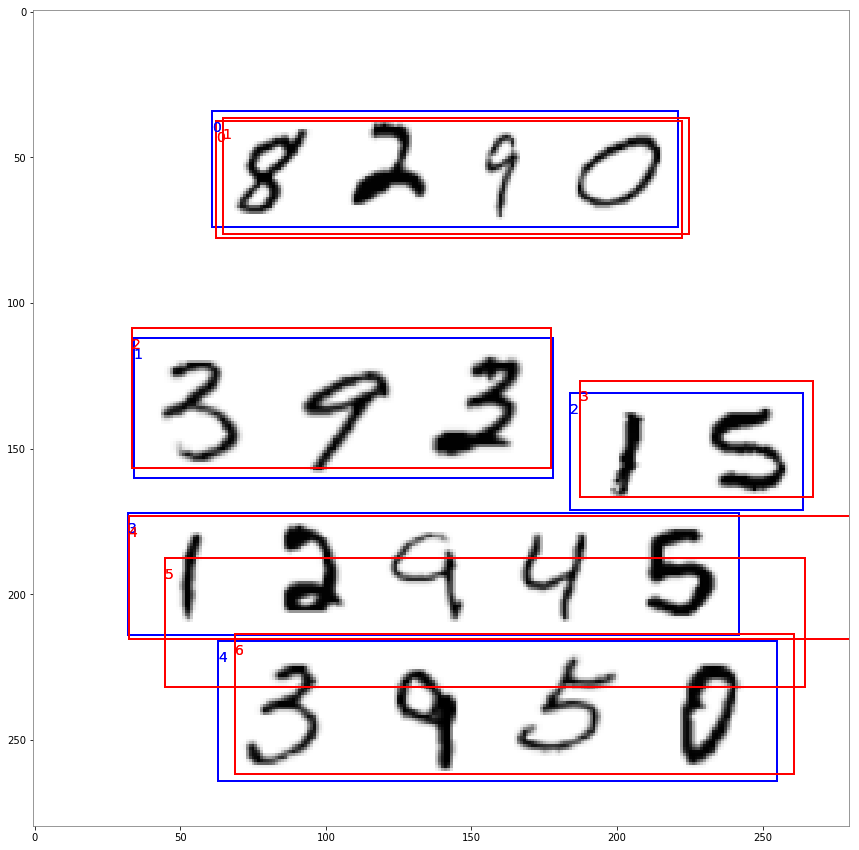

In [69]:
best_number_info = getResultBBox(test_arrays, test_loss_idx[0], digit_size_array, digit_central_ref_array)
vizResult(test_arrays['image_array'], test_loss_idx[0], best_number_info)

In [70]:
best_bbox_mat_dict = getBBoxMat(best_number_info)

### Exemplo com maior perda

label
Number 0 > digit_size: 34.0 | length:  3.0 | tx:  0.0 | ty:  2.0 | coord:[ 53.  83. 155. 117.]
Number 1 > digit_size: 32.0 | length:  3.0 | tx:-10.0 | ty: 14.0 | coord:[ 16. 180. 112. 212.]
Number 2 > digit_size: 28.0 | length:  1.0 | tx: -2.0 | ty: -9.0 | coord:[222. 215. 250. 243.]
Number 3 > digit_size: 32.0 | length:  1.0 | tx: -9.0 | ty: -7.0 | coord:[ 17. 243.  49. 275.]
Number 4 > digit_size: 38.0 | length:  4.0 | tx:  1.0 | ty: -9.0 | coord:[ 52. 238. 204. 276.]
Number 5 > digit_size: 46.0 | length:  5.0 | tx:  3.0 | ty: -6.0 | coord:[ 40.  31. 270.  77.]
Number 6 > digit_size: 44.0 | length:  5.0 | tx:  4.0 | ty:  3.0 | coord:[ 42. 121. 262. 165.]


output
Number 0 > digit_size: 34.0 | length:  3.0 | tx:  4.4 | ty:  2.4 | coord:[ 57.4  83.4 159.4 117.4]
Number 1 > digit_size: 32.0 | length:  3.0 | tx: -8.0 | ty:  6.0 | coord:[ 18. 172. 114. 204.]
Number 2 > digit_size: 30.0 | length:  3.0 | tx: -8.6 | ty: -5.1 | coord:[ 18.4 189.9 108.4 219.9]
Number 3 > digit_size: 28.0

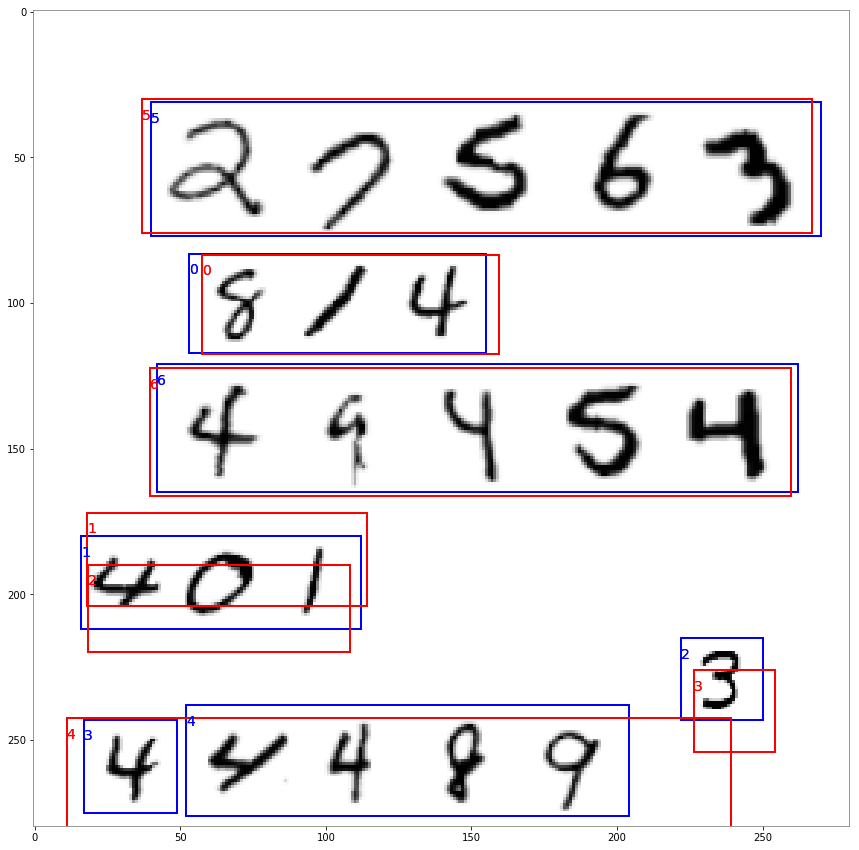

In [45]:
worst_number_info = getResultBBox(test_arrays, test_loss_idx[-1], digit_size_array, digit_central_ref_array)
vizResult(test_arrays['image_array'], test_loss_idx[-1], worst_number_info)